<a href="https://colab.research.google.com/github/fuzhanrahmanian/AI_school_bigmap_2022/blob/main/Tutorial_3_AL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Copyright 2022 Fuzhan Rahmanian (KIT) fuzhan.rahmanian@kit.edu

# Active Learning



In [ ]:
# Import necessary packages

import random
import pickle
import pydot
import pylab
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from IPython.display import Image

For this part of the tutorial, we want to create some synthetic dummy data. We will create a mesh grid and define x and y positions which will be our features/inputs. In practice, this is our search space.
For our output, we will define the 2D-Schwefel Function and get its value given selected x,y positions by the active learning run. 


In [ ]:
# Create a grid with stepsize 2.5 for 21 points.
x_grid, y_grid = np.meshgrid([2.5 * i for i in range(21)], [2.5 * i for i in range(21)])

# Flatten the grid and save the coordinates
x, y = x_grid.flatten(), y_grid.flatten()

In [ ]:
# Define the Schefel function
def schwefel_function(x, y):
    comp = np.array([x, y])
    # scaled and shift values in the right search space
    sch_comp = 20 * np.array(comp) - 500
    result = 0
    for index, element in enumerate(sch_comp):
        result += - element * np.sin(np.sqrt(np.abs(element)))
    return -result / 1000

In [ ]:
# Define features and labels 
features = np.array([[i, j] for i, j in zip(x, y)])
labels = np.array([schwefel_function(x[0], x[1]) for x in features])

## Plotting the input and correspondent output values

In [ ]:
# Plot a counter version of the Schwefel function and overlap it with the meshgrid
# Add a colorbar to identify the maximum

plt.contourf(x_grid, y_grid, np.array(labels).reshape(len(x_grid), len(y_grid)))
plt.scatter(x_grid, y_grid, c="black", s=5)
plt.colorbar()

### Define train and test dataset

We will randomly choose one mesh grid point with its corresponding Schwefel functions value so that the trained dataset has exactly one labeled feature. The remaining points are unlabeled and are considered towards the test dataset.

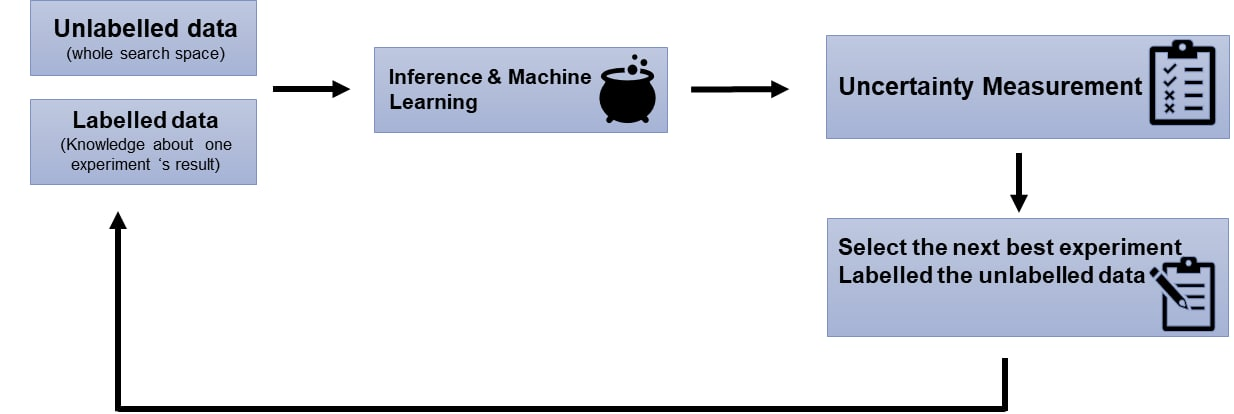

In [ ]:
# Set a seed for comparable result
random.seed(10)

# Choose a rondom value
first_arbitary_ind = random.choice(range(len(features)))
print(features[first_arbitary_ind])

### Select a model

As explained in the previous tutorials, random forest regressor will be selected for this example. 

In [ ]:
# Select a regressor
model = RandomForestRegressor(n_estimators=50, random_state=1337)

### Implement the active learning run

Our active learning run consists of Random Forest Regressor and variance measurement for uncertainty method.



In [ ]:
# Finding top percentile helper function for syntetical data
# With this it is possible to understand how much actual accellartion can be achived
# while using active learning

def find_top_perc(features, lables):
    # Find the top perentile positions
    top_prec = [features[i].tolist() for i in 
                np.where(lables > np.percentile(labels, 99))[0]]
    return top_prec

# Finding the top percentile of synthetic dataset

top_perc = find_top_perc(features, labels)
print(top_perc)

In [ ]:
# Placeholder list for plotting 
sampled_x_points, sampled_y_points = [], []

# Define the active learning run        
def active_learning_run(model, features, labels, rnd_train_ind, top_perc, 
                        sampling_ratio=0.30, num_of_estimator=50):
  """
    Args:
        model (class): the model definition used for the learning
        features (numpy.ndarray): The input array containing the features
        labels (numpy.ndarray): The output array containing the labels
        rnd_train_ind (int): the index of the randomly selected experiment
        top_prec (list): List of points in the top percentile of materials
        sampling_ratio (int, optional): Number of runs for learning activly. Defaults to 35.
        num_of_estimator (int, optional): Number of decision tree regressor. Defaults to 50.
  """
  test_index = [i for i in range(len(features))]
  train_index = [rnd_train_ind]
  num_sampling = int(len(features)*sampling_ratio)
  print(num_sampling)

  for sample in tqdm(range(num_sampling)):
    model.fit(features[train_index], labels[train_index])
    pred = model.predict(features[test_index])
    # Data prediction from each estimator
    y_var = np.zeros([num_of_estimator, len(features[test_index])])
    
    # Get the prediction from each subsample of trees
    for estimator in range(num_of_estimator):
      y_var[estimator, :] = model.estimators_[estimator].predict(features[test_index])

    # Define the Aquisition function for uncertanty measurments
    aqf = pred + np.var(y_var, axis=0) 

    # We are going to chose the value that highest value in the aquisition functions
    # which refers to the most uncertain prediction
    highets_indices = np.where(aqf==np.max(aqf))[0] 
    next_index = np.random.choice(highets_indices)

    # Remove the selected index from the test set, and add it to the train dataset
    # This is done to explore more uncertain datapoints first and increas our
    # prior knowledge
    train_index.append(test_index.pop(next_index))

    # Next selected x and y can be chosen
    next_x, next_y = features[train_index[-1]][0], features[train_index[-1]][1]

    # Append these points to the list for futur plotting
    sampled_x_points.append(next_x)
    sampled_y_points.append(next_y)  

    # Check if the points are in the top 1 percentile of material
    # Interrupt the loop if yes
    if all(elem in [[i, j] for i, j in zip(sampled_x_points, sampled_y_points)] 
           for elem in top_perc):
      print(f"Find all top. Breaking after {sample} iterations...")
      break
    else:
      continue

In [ ]:
# Execute the run
active_learning_run(model = model, features=features, labels=labels,
                    rnd_train_ind=first_arbitary_ind, top_perc = top_perc)


In [ ]:
# Let´s print the predicted points over time
print((f"predicted points are {[[i,j] for i,j in zip(sampled_x_points, sampled_y_points)] }"))

### Visualize the prediction

In [ ]:
plt.figure(figsize=(15, 10), dpi=80)
plt.contourf(x_grid, y_grid, np.array(labels).reshape(len(x_grid), len(y_grid)))
for i in range(len(sampled_y_points)):
  if i != len(sampled_y_points) - 1:
    point_style = "."
  else:
    # Mark the last point
    point_style = "X"
  plt.scatter(sampled_x_points[i], sampled_y_points[i], c="Red", alpha=i/len(sampled_y_points), s=100, marker=point_style)
plt.colorbar()

### Exercise

Applay active learning on the OER dataset. Find the top percentile of materials first, then perform active learning. Plotting is not necessary. 

In [ ]:
# Import the dataset
!wget -O tri_data_share.zip https://drive.google.com/u/0/uc?id=1-jRaEUxu3lHik4itFu9MZVJ8j9rDRCpm&export=download
!unzip tri_data_share.zip

# Open the downloaded data
all_data = pickle.load(open( "tri_data_share.pck", "rb" ))

# Select the space C with id 3890
data = all_data["3860"]

### Advanced Exercise

As an extra, try to use a Guassian process regressor as a machine learning model and use lower confidence bound for measuring the uncertanty at every step active learning run. 
*   Which machine learning model finds the top materials faster? Which one is more accurate?

Use the generated synthetic meshgrid dataset for this. You can also plot the results
